In [2]:
from PIL import Image
import PIL
import time
import math
import numpy as np
import imageio
from ipywidgets import interact
from matplotlib import pyplot as plt

In [3]:
def save(img, name):
    img.save(name + ".png", "PNG")

def open(imgname):
    return Image.open(imgname)

def load(image):
    return image.load()

In [4]:
def distance(c1,c2):
    r1,g1,b1 = c1
    r2,g2,b2 = c2
    return math.sqrt(((r2-r1)**2+(g2-g1)**2+(b2-b1)**2))

In [5]:
cscale = [(0, 0, 255),(0, 48, 255),(0, 96, 255),(0, 144, 255),(0, 192, 255),(0, 240, 255),(0, 255, 191),(0, 255, 95),(0, 255, 0),(48, 255, 0),(96, 255, 0),(144, 255, 0),(192, 255, 0),(239, 255, 0),(255, 224, 0),(255, 176, 0),(255, 128, 0),(255, 80, 0),(255, 32, 0),(255, 15, 15),(255, 63, 63),(255, 111, 111),(255, 159, 159),(255, 207, 207),(255, 255, 255)]

In [6]:
def scale2height(x):                  #for any (above sea level) given map: plug (0 - 25) and (bottomHeight - topHeight) in 
    a=0.000023                            #https://stats.blue/Stats_Suite/polynomial_regression_calculator.html  with 4th degree 
    b=-0.002135                           #and a sufficient number of digits, then copy the coefficients here and run the script
    c=0.112806
    d=1.081289
    e=-1.176363
    return (a*x**4+b*x**3+c*x**2+d*x+e)
    
def scale2color(x):
    if x>=0 and x<=8:        #red
        red=0
    elif x>8 and x<=13.33:
        red=48*(x-8)
    elif x>13.33 and x<=24:
        red=255
    if x>=0 and x<=5.33:         #green
        green=48*x
    elif x>5.33 and x<=13.33:
        green=255
    elif x>13.33 and x<=18.66:
        green=224-48*(x-14)
    elif x>18.66 and x<=24:
        green=15+48*(x-19)
    if x>=0 and x<=5.33:         #blue
        blue=255
    elif x>5.33 and x<=8:
        blue=192-96*(x-6)
    elif x>8 and x<=18.33:
        blue=0
    elif x>18.33 and x<=24:
        blue=15+48*(x-19)
    return (red,green,blue)
        
def color2scale(c):
    r,g,b = c
    if r==0 and b==255:
        return g/48
    if r==0 and g==255:
        return (192-b)/96+6
    if g==255 and b==0:
        return r/48+8
    if r==255 and b==0:
        return (224-g)/48+14
    if g==b and r==255:
        return (g-15)/48+19

def mins(c, scale):            #2 smallest values of the distances
    ds= {distance(c,c1):c1 for c1 in scale}
    a=scale.index(ds[min(ds)])
    del ds[min(ds)]
    ind1, ind2 = (a,scale.index(ds[min(ds)]))           #gives back the indexes in the cscale of the two closest colours
    if ind2<=ind1:
        ind2, ind1 = ind1, ind2
    if ind2-ind1 > 2:
        if ind1 == 0:
            ind2 = ind1 + 1
        else:
            ind1 -= 1
            ind2 = ind1 + 2
    return (ind1, ind2)
    
def closestX(c, precision):                    #gives back the closest value in the continuous scale
    ind1, ind2 = mins(c, cscale)
    closestdistance = 1000
    for i in range(precision + 1):
        calc = ind1 + i*(ind2-ind1)/precision
        d = distance(c,scale2color(calc))
        if d < closestdistance:
            closestdistance = d
            closestcolor = calc
    return closestcolor

def color2height(c,precision):
    return scale2height(closestX(c,precision))

In [7]:
def matrix_create(img, precision):
    img_colors = img.convert('RGB')
    img_colorpixels = load(img_colors)
    width = img.size[0]
    height = img.size[1]
    res = np.zeros((height,width))
    for x in range(width):
        for y in range(height):
            res[y,x] = color2height(img_colorpixels[x,y], precision)
    return res

In [8]:
def matrix_save(img, precision, name):
    img_colors = img.convert('RGB')
    img_colorpixels = load(img_colors)
    width = img.size[0]
    height = img.size[1]
    res = np.zeros((height,width))
    for x in range(width):
        for y in range(height):
            res[y,x] = color2height(img_colorpixels[x,y], precision)
    np.savetxt(name + ".txt", res)

In [9]:
#matrix_save(open('TJEX.png'), 400, 'TJEX_matrix')

In [10]:
#tjex_matrix = matrix_create(open('TJEX.png'), 400)
tjex_matrix = np.loadtxt('TJEX_matrix.txt')

In [11]:
def matrixtopofind(matrix_img, rise):
    res = 0
    width = len(matrix_img[0])
    height = len(matrix_img)
    for x in range(width):
        for y in range(height):
            if matrix_img[y,x] <= rise:
                res += 1
    return res

In [12]:
def matrixtopofind_ori(matrix_img, rise):
    res = set()
    width = len(matrix_img[0])
    height = len(matrix_img)
    for x in range(width):
        for y in range(height):
            if matrix_img[y,x] <= rise:
                res.add((x,y))
    return res

In [13]:
def popcolor(color):
    if color == (255,0,0):
        return 0
    r,g,b = color
    return int(-2668.530454 + 94.715665*r + 692.062875*g - 71.699362*b)

In [14]:
def popfunc(color, cdict):
    if color == (255,0,0):
        return 0
    popc = popcolor(color)
    colorcount = cdict[color]
    return popc/colorcount

In [15]:
def color_matrix_create(img):
    img_colors = img.convert('RGB')
    img_colorpixels = load(img_colors)
    width = img.size[0]
    height = img.size[1]
    res = []
    tempres = []
    for x in range(width):
        for y in range(height):
            tempres.append(img_colorpixels[x,y])
        res.append(tempres)
        tempres = []
    return res

In [16]:
def colordict(color_matrix):
    res = {}
    width = len(color_matrix[0])
    height = len(color_matrix)
    for x in range(width):
        for y in range(height):
            c = color_matrix[y][x]
            if c != (255,0,0):
                if c in res:
                    res[c] += 1
                else:
                    res[c] = 1
    return res

In [17]:
def pop_matrix_create(color_matrix):
    width = len(color_matrix[0])
    height = len(color_matrix)
    res = np.zeros((height,width))
    cdict = colordict(color_matrix)
    for x in range(width):
        for y in range(height):
            res[y,x] = popfunc(color_matrix[y][x], cdict)
    return res

In [18]:
color_matrix = color_matrix_create(open('Jakarta_popmap_fix.png'))
pop_matrix = pop_matrix_create(color_matrix)

In [19]:
def matrixtopopopfind(matrix_img, popmatrix, rise):
    pixelcount = 0
    peoplecount = 0
    width = len(matrix_img[0])
    height = len(matrix_img)
    for x in range(width):
        for y in range(height):
            if matrix_img[y,x] <= rise:
                pixelcount += 1
                peoplecount += popmatrix[x][y]
    return (pixelcount, peoplecount)

In [20]:
def matrixtoposubmerge(img, matrix_img, rise):
    submerge = matrixtopofind_ori(matrix_img, rise)
    img_name = img.filename
    img_colors = img.convert('RGB')
    img_colorpixels = load(img_colors)
    for pixel in submerge:
        x,y = pixel
        img_colorpixels[x,y] = (78,98,155)
    return img_colors

In [21]:
def submergemain():
    matrixcheck = input('Use pre-computed 400 precision matrix for TJEX.png? (yes or no): ')
    if matrixcheck in 'yesokayuse':
        matrix_img = tjex_matrix
        HQimg = open('TJEXHQres.png')
    else:
        LQimg = open(input('LQ File name: '))
        HQimg = open(input('HQ File name: '))
        precision = int(input('Precision: '))
        print('Creating matrix...')
        startmatrix = time.time()
        matrix_img = matrix_create(LQimg, precision)
        endmatrix = time.time()
        print('Created matrix in ' + str(round(endmatrix-startmatrix,4)) + ' seconds.')
    pop_matrix = pop_matrix_create(color_matrix_create(open('Jakarta_popmap_fix.png')))
    subpixels = 0
    peopletemp = 0
    submerging = []
    displacing = []
    meters = []
    images = []
    pixel2meter = 110
    riseinc = float(input('Increments of __ meters: '))
    riseupto = float(input('Rise up to __ meters: '))
    print('Processing images...')
    startall = time.time()
    for i in range(int(riseupto/riseinc) + 1):
        data = matrixtopopopfind(matrix_img, pop_matrix, round(i*riseinc,5))
        pixelcount, peoplecount = data
        peoplecount = int(peoplecount)
        submerging.append(abs(round(pixelcount*((pixel2meter/1000)**2) - 1457.97,2)))
        displacing.append(int(peoplecount) - 34985)
        meters.append(round(i*riseinc,5))
        #images.append(matrixtoposubmerge(HQimg, matrix_img, round(i*riseinc,5)))
    endall = time.time()
    print('Submerged a total of', abs(round(pixelcount*((pixel2meter/1000)**2) - 1457.97,2)), 'km^2 by rising up to', riseupto, 'meters. Processing took', round(endall-startall,4), 'seconds')
    plt.show(plt.plot(meters, submerging))
    print("{:,}".format(int(peoplecount) - 34985), ' people have been displaced by rising water levels.')
    plt.show(plt.plot(meters, displacing))
    display(matrixtoposubmerge(HQimg,matrix_img,riseupto))
    #display(images[len(images) - 1])

In [22]:
def statsupto(img, matrix_img, popmatrix, rise, pixel2meter):
    a,b = matrixtopopopfind(matrix_img,popmatrix,rise)
    print(abs(round(a*((pixel2meter/1000)**2) - 1457.97,2)), 'km^2 submerged')
    print("{:,}".format(int(b) - 34985), 'people displaced')
    display(matrixtoposubmerge(img, matrix_img, rise))

In [23]:
TJEXHQ = open('TJEXHQres.png')

In [73]:
cmax = int(input('Maximum height? (in centimeters): '))
@interact(cm = (0,cmax))
def interactive(cm):
    print('At', cm, 'centimeters, (' + str(cm/100), 'meters):')
    statsupto(TJEXHQ, tjex_matrix, pop_matrix, cm/100, 110)

Maximum height? (in centimeters): 435


interactive(children=(IntSlider(value=217, description='cm', max=435), Output()), _dom_classes=('widget-intera…

In [25]:
data45 = [[0.0170, 0.0281, 0.0419, 0.0548, 0.0632, 0.0738],
          [0.0422, 0.0598, 0.0806, 0.1032, 0.1202, 0.1378],
          [0.0676, 0.0947, 0.1251, 0.1580, 0.1799, 0.2039],
          [0.0972, 0.1310, 0.1763, 0.2244, 0.2566, 0.2920],
          [0.1224, 0.1673, 0.2286, 0.2902, 0.3378, 0.3940],
          [0.1533, 0.2100, 0.2885, 0.3737, 0.4442, 0.4988],
          [0.1803, 0.2469, 0.3399, 0.4355, 0.5128, 0.6085],
          [0.2117, 0.3041, 0.4093, 0.5373, 0.6411, 0.7435],
          [0.2273, 0.3310, 0.4731, 0.6318, 0.7331, 0.8445],
          [0.2380, 0.3757, 0.5306, 0.7134, 0.8562, 1.0045]]

In [26]:
data85 = [[0.0174, 0.0281, 0.0420, 0.0564, 0.0663, 0.0762],
          [0.0453, 0.0613, 0.0840, 0.1065, 0.1224, 0.1407],
          [0.0771, 0.0995, 0.1325, 0.1654, 0.1914, 0.2124],
          [0.1065, 0.1441, 0.1866, 0.2387, 0.2797, 0.3153],
          [0.1498, 0.1959, 0.2598, 0.3259, 0.3698, 0.4250],
          [0.1849, 0.2475, 0.3312, 0.4131, 0.4849, 0.5293],
          [0.2453, 0.3128, 0.4217, 0.5443, 0.6288, 0.7109],
          [0.2745, 0.3905, 0.5203, 0.6694, 0.7967, 0.9051],
          [0.3480, 0.4621, 0.6299, 0.7991, 0.9465, 1.0960],
          [0.3884, 0.5316, 0.7492, 0.9512, 1.1506, 1.3426]]

In [27]:
def interactive4585():
    scen = int(float(input('Scenario? (4.5 or 8.5): ')))
    pval = float(input('P-value? (0.05, 0.17, 0.5, 0.83, 0.95, 0.99): '))
    pval = int((pval + 0.83)**2.7)
    risedata45 = data45
    risedata85 = data85
    if scen == 4:
        @interact(year = (2010,2100, 10))
        def interactive45(year):
            print('At', int(risedata45[(year-2010)//10][pval]*100), 'centimeters, (' + str(round(risedata45[(year-2010)//10][pval],2)), 'meters):')
            statsupto(TJEXHQ, tjex_matrix, pop_matrix, risedata45[(year-2010)//10][pval], 110)
    else:
        @interact(year = (2010,2100, 10))
        def interactive85(year):
            print('At', int((risedata85[(year-2010)//10][pval])*100), 'centimeters, (' +  str(round(risedata85[(year-2010)//10][pval],2)), 'meters):')
            statsupto(TJEXHQ, tjex_matrix, pop_matrix, risedata85[(year-2010)//10][pval], 110)

In [28]:
def interactive4585_2inter():
    risedata45 = data45
    risedata85 = data85
    pval = float(input('P-value? (0.05, 0.17, 0.5, 0.83, 0.95, 0.99): '))
    pval = int((pval + 0.83)**2.7)
    @interact(scen = (4.5,8.5,4))
    def interactivescen(scen):
        if scen == 4:
            @interact(year = (2010,2100, 10))
            def interactive45(year):
                print(45)
                print('At', int(risedata45[(year-2010)//10][pval]*100), 'centimeters, (' + str(round(risedata45[(year-2010)//10][pval],2)), 'meters):')
                statsupto(TJEXHQ, tjex_matrix, pop_matrix, risedata45[(year-2010)//10][pval], 110)
        else:
            @interact(year = (2010,2100, 10))
            def interactive85(year):
                print(85)
                print('At', int((risedata85[(year-2010)//10][pval])*100), 'centimeters, (' +  str(round(risedata85[(year-2010)//10][pval],2)), 'meters):')
                statsupto(TJEXHQ, tjex_matrix, pop_matrix, risedata85[(year-2010)//10][pval], 110)

In [76]:
interactive4585()

Scenario? (4.5 or 8.5): 8.5
P-value? (0.05, 0.17, 0.5, 0.83, 0.95, 0.99): 0.99


interactive(children=(IntSlider(value=2050, description='year', max=2100, min=2010, step=10), Output()), _dom_…

In [45]:
import random
distance_sol_terre=149500000000#m
puissance_solaire=3.84*10**26#w
#1Gt CO2 = 0.127ppm
def puissance_solaire_terre(distance_sol_terre,puissance_solaire):
    surface_sphere_ter=4*math.pi*6370000**2#5.1*10**14#m^2
    surface_sphere_sol_ter=4*math.pi*distance_sol_terre**2#m^2
    puissance_recu_sphere_sol_ter=puissance_solaire/surface_sphere_sol_ter#w/m^2
    surface_disque_ter=math.pi*6370000**2
    puissance_recu_ter_disque=puissance_recu_sphere_sol_ter*surface_disque_ter#w
    puissance_recu_ter= puissance_recu_ter_disque/surface_sphere_ter#w/m^2
    return puissance_recu_ter

def interface_atmosphere(puissance_solaire_t,albedo):
    temperature_at=((1-albedo)*puissance_solaire_t)#en k
    temperature_te=((2*temperature_at)/(5.67*10**(-8)))**(1/4)
    rayonnement_terrestre=(2.898*10**(-3))/temperature_at#m
    tmp2=rayonnement_terrestre*1000000#micrometre
    return tmp2,temperature_at,temperature_te

def conversion(valeur):
    return valeur-273

def forcage_radiatif(valeur):
    return 5.35*math.log((280+valeur)/280)

def ocean(temperature):
    a=0.00017*1.4*10**18*temperature
    return a/(3.6*10**14)

def cycleCarbone(atmosphere,biosphere,hydrosphere,lithosphere,combustionMassive):#intervention de l'homme):
  photosynthese=62
  respiration=60
  fossilisation=0.1
  volcanisme=0.1 
  sedimentation=0.3
  dissolution=2
  atmosphere=atmosphere-photosynthese+respiration+volcanisme+combustionMassive-dissolution
  biosphere=biosphere-respiration+photosynthese-fossilisation
  hydrosphere=hydrosphere-fossilisation-sedimentation+dissolution
  lithosphere=lithosphere-volcanisme+sedimentation+fossilisation*2
  return (atmosphere,biosphere,hydrosphere,lithosphere)

def converstion_gt_ppm(valeur):
  return valeur/7.829

def cycle(atmosphere,biosphere,hydrosphere,lithosphere,carbonne,albedo):
    atmosphere,biosphere,hydrosphere,lithosphere=cycleCarbone(atmosphere,biosphere,hydrosphere,lithosphere,carbonne)
    carbone_enpmm=converstion_gt_ppm(atmosphere)
    t=puissance_solaire_terre(distance_sol_terre,puissance_solaire)*0.7+forcage_radiatif(carbone_enpmm)
    a,b,c=interface_atmosphere(t,albedo)
    return ocean(conversion(c)*0.01),atmosphere,biosphere,hydrosphere,lithosphere

In [108]:
c = 32

str(cycle(750,2000,39000,30000000,c,0.07)[0]*100) + ' cm d\'augmentation par rapport à ' + str(c) + ' Gt d\'emissions.'

def florent_gt2m(c):
    return cycle(750,2000,39000,30000000,c,0.07)[0]

florent_gt2m(32)

0.16627800222932193

In [110]:
def data_create_florent(Gtpardec):
    res = []
    rise = -0.192288 #calculé sur Gt en 1990-2000
    for i in Gtpardec:
        res.append(rise + florent_gt2m(i))
        rise += florent_gt2m(i)
    return res

def data_main_florent():
    res = [295.15, 355.29]
    for i in range(8):
        res.append(float(input(str(i*10+2020) + '-' + str(i*10+2030) + ' CO2 emissions (in Gt): ')))
    return data_create_florent(res)

In [111]:
data_main_florent()

2020-2030 CO2 emissions (in Gt): 400
2030-2040 CO2 emissions (in Gt): 450
2040-2050 CO2 emissions (in Gt): 500
2050-2060 CO2 emissions (in Gt): 600
2060-2070 CO2 emissions (in Gt): 800
2070-2080 CO2 emissions (in Gt): 1000
2080-2090 CO2 emissions (in Gt): 2000
2090-2100 CO2 emissions (in Gt): 5000


[-0.025081604061048507,
 0.1423261680501689,
 0.30988124168461867,
 0.4775986881175446,
 0.6454760894651432,
 0.8136664255813989,
 0.9824565210603879,
 1.1518146050854339,
 1.3236329471188406,
 1.5005827965599507]

In [104]:
reg1020 = [295.15, 355.29]
reg1020 += [60.14 * (x + 3) + 235.01 for x in range(8)]
data1020 = data_create_florent(reg1020)
data1020

[-0.025081604061048507,
 0.1423261680501689,
 0.3099316122397199,
 0.4777311571901388,
 0.6457213573649436,
 0.8138988864954776,
 0.9822605315092428,
 1.1508031868629685,
 1.3195238492472658,
 1.4884196126329292]

In [77]:
def Gt2m(val):
    return val * 0.0008012 #calculé sur Gt / ppm / m entre 2000-2020

def data_create(Gtpardec):
    res = []
    rise = -0.192288 #calculé sur Gt en 1990-2000
    for i in Gtpardec:
        res.append(rise + Gt2m(i))
        rise += Gt2m(i)
    return res

def data_main():
    res = [295.15, 355.29]
    for i in range(8):
        res.append(float(input(str(i*10+2020) + '-' + str(i*10+2030) + ' CO2 emissions (in Gt): ')))
    return data_create(res)

In [78]:
reg1020 = [295.15, 355.29]
reg1020 += [60.14 * (x + 3) + 235.01 for x in range(8)]
data1020 = data_create(reg1020)
data1020

[0.04418617999999999,
 0.32884452799999997,
 0.661687044,
 1.0427137279999998,
 1.4719245799999998,
 1.9493196,
 2.474898788,
 3.0486621439999997,
 3.6706096679999995,
 4.340741359999999]

In [70]:
reg1020ind = [295.15, 355.29]
reg1020ind += [(60.14 * (x + 3) + 235.01)*0.985 for x in range(8)]
data1020ind = data_create(reg1020ind)
data1020ind

[0.04418617999999999,
 0.32884452799999997,
 0.65669440626,
 1.0320056899999999,
 1.45477837922,
 1.9250124739199999,
 2.4427079740999997,
 3.0078648797599996,
 3.6204831908999995,
 4.280562907519999]

In [109]:
#Sans aucun emissions d'Indonésie, le resultat change de 6 cm en 2100

In [74]:
data_test = data_main()
data_test

2020-2030 CO2 emissions (in Gt): hg


ValueError: could not convert string to float: 'hg'

In [66]:
def data_main_0ind():
    res = [295.15, 355.29]
    for i in range(8):
        res.append(float(input(str(i*10+2020) + '-' + str(i*10+2030) + ' CO2 emissions (in Gt): '))*0.985)
    return data_create(res)

In [67]:
data_main_0ind()

2020-2030 CO2 emissions (in Gt): 420
2030-2040 CO2 emissions (in Gt): 440
2040-2050 CO2 emissions (in Gt): 460
2050-2060 CO2 emissions (in Gt): 470
2060-2070 CO2 emissions (in Gt): 460
2070-2080 CO2 emissions (in Gt): 450
2080-2090 CO2 emissions (in Gt): 430
2090-2100 CO2 emissions (in Gt): 410


[0.04418617999999999,
 0.32884452799999997,
 0.6603009679999999,
 1.0075410479999998,
 1.3705647679999997,
 1.7414803079999996,
 2.1045040279999996,
 2.4596359279999995,
 2.7989841879999995,
 3.1225488079999995]

In [ ]:
risedata = data1020
@interact(year = (2010,2100, 10))
def interactive45_florent(year):
    print('At', int(round(data1020_florent[(year-2010)//10],2)*100), 'centimeters, (' + str(round(data1020[(year-2010)//10],2)), 'meters):')
    statsupto(TJEXHQ, tjex_matrix, pop_matrix, data1020[(year-2010)//10], 110)

In [79]:
risedata = data1020
@interact(year = (2010,2100, 10))
def interactive45(year):
    print('At', int(round(data1020[(year-2010)//10],2)*100), 'centimeters, (' + str(round(data1020[(year-2010)//10],2)), 'meters):')
    statsupto(TJEXHQ, tjex_matrix, pop_matrix, data1020[(year-2010)//10], 110)

interactive(children=(IntSlider(value=2050, description='year', max=2100, min=2010, step=10), Output()), _dom_…

In [60]:
risedata = data_test
@interact(year = (2010,2100, 10))
def interactive45(year):
    print('At', int(round(data_test[(year-2010)//10],2)*100), 'centimeters, (' +str(round(data_test[(year-2010)//10],2)), 'meters):')
    statsupto(TJEXHQ, tjex_matrix, pop_matrix, data1020[(year-2010)//10], 110)

interactive(children=(IntSlider(value=2050, description='year', max=2100, min=2010, step=10), Output()), _dom_…

Use pre-computed 400 precision matrix for TJEX.png? (yes or no): yes
Increments of __ meters: 0.05
Rise up to __ meters: 4
Processing images...
Submerged a total of 667.19 km^2 by rising up to 4.0 meters. Processing took 11.9222 seconds


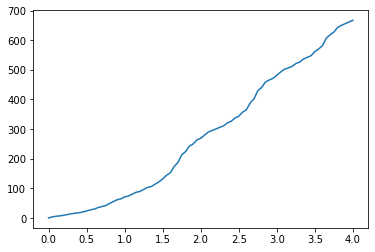

1,411,927  people have been displaced by rising water levels.


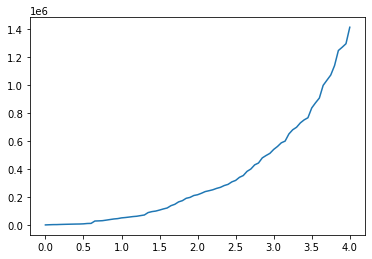

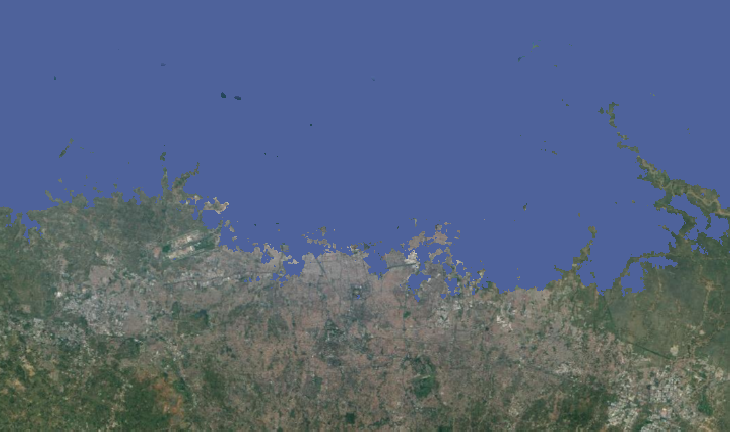

In [35]:
submergemain()